In [102]:
import os
import sys
import polars as pl
import polars.selectors as cs

from datetime import datetime

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

unflagged_data = False

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import DESPIKED_DATA_DIRECTORY
from utils.config_files import load_json_config
from config.sites_deloyment_times import deployment_times
from utils.import_data import import_acropolis_site_data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

assert(os.path.exists(DESPIKED_DATA_DIRECTORY))

In [103]:
# load files
config = load_json_config("config.json")

for site in config["icos_cities_portal"]["site_names"]:
    pass

site = "DLRR"
df = import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                    deployment_times=deployment_times,
                                    site_name=site)
    


In [104]:
df = df.with_columns(
    pl.col("datetime")
    .dt.convert_time_zone("Europe/Berlin")
    .alias("datetime_local")) \
    .with_columns(pl.col("datetime_local").dt.ordinal_day().alias("day_of_year"),
                     pl.col("datetime_local").dt.weekday().alias("day_of_week"),
                     pl.col("datetime_local").dt.hour().alias("hour_of_day"))

In [105]:
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
winter = list(range(355, 367)) + list(range(0, 80))

df = df.with_columns(
    pl.when(pl.col("day_of_year").is_in(spring)).then(pl.lit("spring"))
    .when(pl.col("day_of_year").is_in(summer)).then(pl.lit("summer"))
    .when(pl.col("day_of_year").is_in(fall)).then(pl.lit("fall"))
    .when(pl.col("day_of_year").is_in(winter)).then(pl.lit("winter"))
    .otherwise(None)
    .alias("season")
).sort("hour_of_day")

In [106]:
df_summer = df.filter(pl.col("season") == "summer").group_by("hour_of_day").agg(pl.col("gmp343_corrected").mean().alias("mean_co2_summer"))

df_fall = df.filter(pl.col("season") == "fall").group_by("hour_of_day").agg(pl.col("gmp343_corrected").mean().alias("mean_co2_fall"))

df_winter = df.filter(pl.col("season") == "winter").group_by("hour_of_day").agg(pl.col("gmp343_corrected").mean().alias("mean_co2_winter"))

df_spring = df.filter(pl.col("season") == "spring").group_by("hour_of_day").agg(pl.col("gmp343_corrected").mean().alias("mean_co2_spring"))

In [107]:
df_plot = df_summer.join(df_fall, on="hour_of_day", how="left") \
    .join(df_winter, on="hour_of_day", how="left") \
    .join(df_spring, on="hour_of_day", how="left") \
    .sort("hour_of_day")

In [108]:
df_plot

hour_of_day,mean_co2_summer,mean_co2_fall,mean_co2_winter,mean_co2_spring
i8,f64,f64,f64,f64
0,469.405444,451.562938,454.443827,450.168637
1,472.602579,452.724683,453.90557,451.941098
2,474.331636,452.701044,455.072888,453.54856
3,477.9027,452.342343,453.754325,455.308043
4,481.41416,450.720736,456.052027,457.913365
…,…,…,…,…
19,426.051514,443.7782,448.62364,428.118133
20,433.195804,445.893894,450.225932,431.933081
21,445.678976,448.320357,452.459346,439.128326


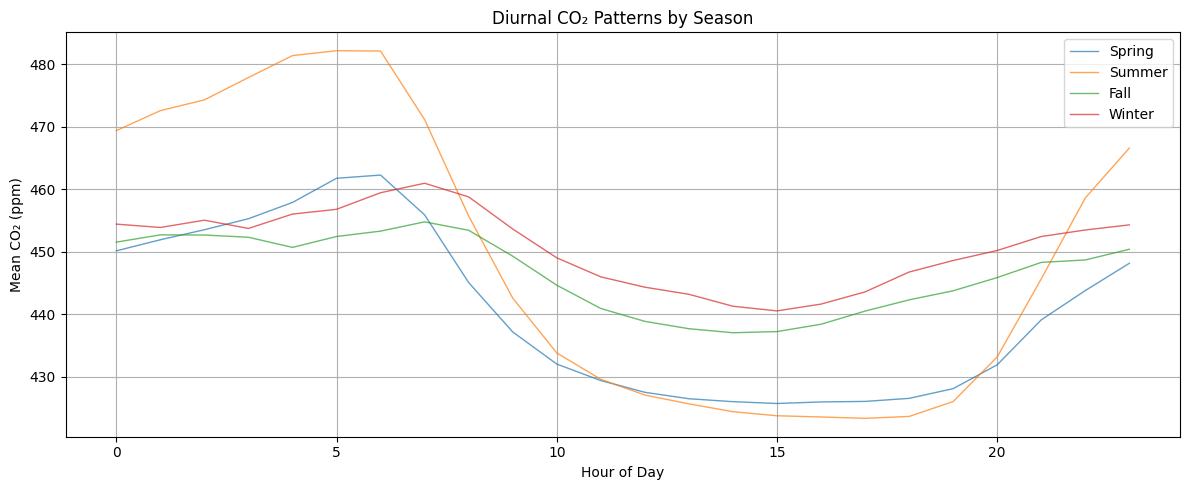

In [109]:
x_values = df_summer["hour_of_day"].to_numpy()
y_summer = df_summer["mean_co2_summer"].to_numpy()
y_fall = df_fall["mean_co2_fall"].to_numpy()
y_winter = df_winter["mean_co2_winter"].to_numpy()
y_spring = df_spring["mean_co2_spring"].to_numpy()

plt.figure(figsize=(12, 5))

plt.plot(x_values, y_spring, label="Spring", alpha=0.7, linewidth=1)
plt.plot(x_values, y_summer, label="Summer", alpha=0.7, linewidth=1)
plt.plot(x_values, y_fall, label="Fall", alpha=0.7, linewidth=1)
plt.plot(x_values, y_winter, label="Winter", alpha=0.7, linewidth=1)

plt.xlabel("Hour of Day")
plt.ylabel("Mean CO₂ (ppm)")
plt.title("Diurnal CO₂ Patterns by Season")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()